In [152]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

c = 299_800_000

In [153]:
def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
        return normalisation_coeffient *np.exp(exponent), normalisation_coeffient
    else:
        return normalisation_coeffient *np.exp(exponent)

In [154]:
array_length = 400 #in pixels
pixel_pitch = 50 #in um
central_freq = 3 #in THz
FWHM_freq = 3 #in THz
theta = 60 #in arcminutes
number_of_averages = 20 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [155]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /c #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /c # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


57.2604893728845


In [156]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = c *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
#phase = [(-1)**n for n in range(len(wavenumbers))] #ensure that the interferogram is centered and has a positive central fringe
amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)
#amplitudes = phase *amplitudes
intensity = np.fft.irfft(amplitudes, norm= "forward")

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = c *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_phase = [(-1)**n for n in range(len(oversampled_wn))] #ensure that the interferogram is centered and has a positive central fringe
oversampled_amps = oversampled_phase *gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber, normalisation_coeffient= normalisation_coeffient)

In [157]:
####### ADD INCOHERANCE ###########

incoherance_sigma = 2
number_of_waves = 200 # More waves will create more destructive interferance. The phase will converge but the amplitude will die out.

number_of_freqs = len(freqs)
noise = np.random.normal(0, incoherance_sigma, (number_of_waves, number_of_averages, number_of_freqs))
noise = np.exp(1j*noise)
noise = np.mean(noise, axis= 0)

incoherent_amps = amplitudes *noise # BE CAREFUL WITH THIS! Amplitudes is being broadcasted into a new shape

In [158]:
####### IFFT TO MAKE INTERFEROGRAMS ###########

incoherent_intensity = np.fft.irfft(incoherent_amps, norm= "forward", axis= 1)

In [159]:
####### ADD READ NOISE ########

read_noise_sigma = 0

noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_length))
noisy_intensity = incoherent_intensity +noise
noisy_amps = np.fft.rfft(noisy_intensity, norm= "forward", axis= 1)


In [160]:
########## 'TEMPORAL' AVERAGE ############

uncertainty = np.std(noisy_intensity, axis= 0)
averaged_intensity = np.mean(noisy_intensity, axis= 0)

averaged_amps = np.fft.rfft(averaged_intensity, norm= "forward")

In [161]:
########## SHIFT ALL INTERFEROGRAMS AROUND 0 ############

displacement = [n *pixel_pitch*1e-3 for n in range(array_length)]
displacement = np.array(displacement) - (pixel_pitch*1e-3* array_length//2)

intensity = np.fft.fftshift(intensity)
incoherent_intensity = np.fft.fftshift(incoherent_intensity, axes= 1)
noisy_intensity = np.fft.fftshift(noisy_intensity, axes= 1)
averaged_intensity = np.fft.fftshift(averaged_intensity)


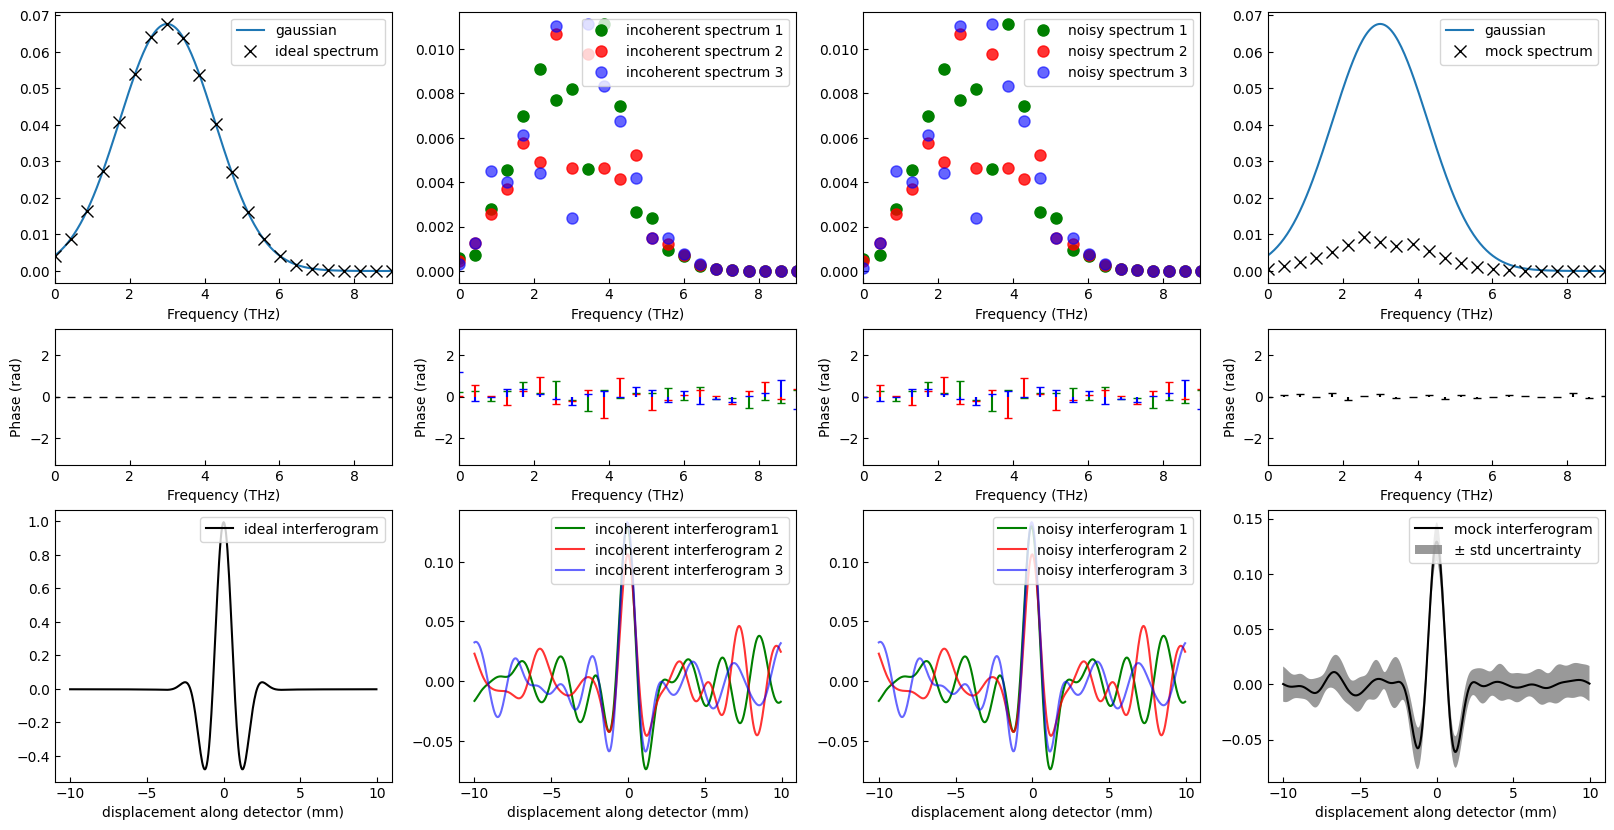

In [162]:
########## MEGACHONKER GRAPH ##############

mosaic = [["spec 1", "spec 2", "spec 3", "spec 4",],
          ["phase 1", "phase 2", "phase 3", "phase 4",],
          ["ifft 1", "ifft 2", "ifft 3", "ifft 4"]]

fig, axs = plt.subplot_mosaic(mosaic, figsize= (20,10), height_ratios= (1, 0.5, 1))

axs["spec 1"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec 1"].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "ideal spectrum")
axs["spec 1"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 1"].legend(loc ="upper right")

axs["phase 1"].stem(freqs, np.angle(amplitudes), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs["phase 1"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 1"].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs["ifft 1"].set(xlabel= "displacement along detector (mm)")
axs["ifft 1"].legend(loc ="upper right")

axs["spec 2"].plot(freqs, np.abs(incoherent_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "incoherent spectrum 1")
axs["spec 2"].plot(freqs, np.abs(incoherent_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "incoherent spectrum 2")
axs["spec 2"].plot(freqs, np.abs(incoherent_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "incoherent spectrum 3")
axs["spec 2"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 2"].legend(loc ="upper right")

axs["phase 2"].stem(freqs, np.angle(incoherent_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs["phase 2"].stem(freqs, np.angle(incoherent_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs["phase 2"].stem(freqs, np.angle(incoherent_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs["phase 2"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 2"].plot(displacement, incoherent_intensity[0], color= "green", alpha= 1, label= "incoherent interferogram1")
axs["ifft 2"].plot(displacement, incoherent_intensity[1], color= "red", alpha= 0.8, label= "incoherent interferogram 2")
axs["ifft 2"].plot(displacement, incoherent_intensity[2], color= "blue", alpha= 0.6, label= "incoherent interferogram 3")
axs["ifft 2"].set(xlabel= "displacement along detector (mm)")
axs["ifft 2"].legend(loc ="upper right")

axs["spec 3"].plot(freqs, np.abs(noisy_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "noisy spectrum 1")
axs["spec 3"].plot(freqs, np.abs(noisy_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "noisy spectrum 2")
axs["spec 3"].plot(freqs, np.abs(noisy_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "noisy spectrum 3")
axs["spec 3"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 3"].legend(loc ="upper right")

axs["phase 3"].stem(freqs, np.angle(noisy_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs["phase 3"].stem(freqs, np.angle(noisy_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs["phase 3"].stem(freqs, np.angle(noisy_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs["phase 3"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 3"].plot(displacement, noisy_intensity[0], color= "green", alpha= 1, label= "noisy interferogram 1")
axs["ifft 3"].plot(displacement, noisy_intensity[1], color= "red", alpha= 0.8, label= "noisy interferogram 2")
axs["ifft 3"].plot(displacement, noisy_intensity[2], color= "blue", alpha= 0.6, label= "noisy interferogram 3")
axs["ifft 3"].set(xlabel= "displacement along detector (mm)")
axs["ifft 3"].legend(loc ="upper right")

axs["spec 4"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec 4"].plot(freqs, np.abs(averaged_amps), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "mock spectrum")
axs["spec 4"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 4"].legend(loc ="upper right")

axs["phase 4"].stem(freqs, np.angle(averaged_amps), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs["phase 4"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 4"].plot(displacement, averaged_intensity, color= "k", label= "mock interferogram")
axs["ifft 4"].set(xlabel= "displacement along detector (mm)")
axs["ifft 4"].fill_between(displacement, averaged_intensity-uncertainty, averaged_intensity+uncertainty, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs["ifft 4"].legend(loc ="upper right")

plt.show()

In [164]:
to_save = np.array([averaged_intensity, uncertainty]).T
#np.savetxt("data\\1dmockanderrors3.csv", to_save, delimiter=",")